In [13]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


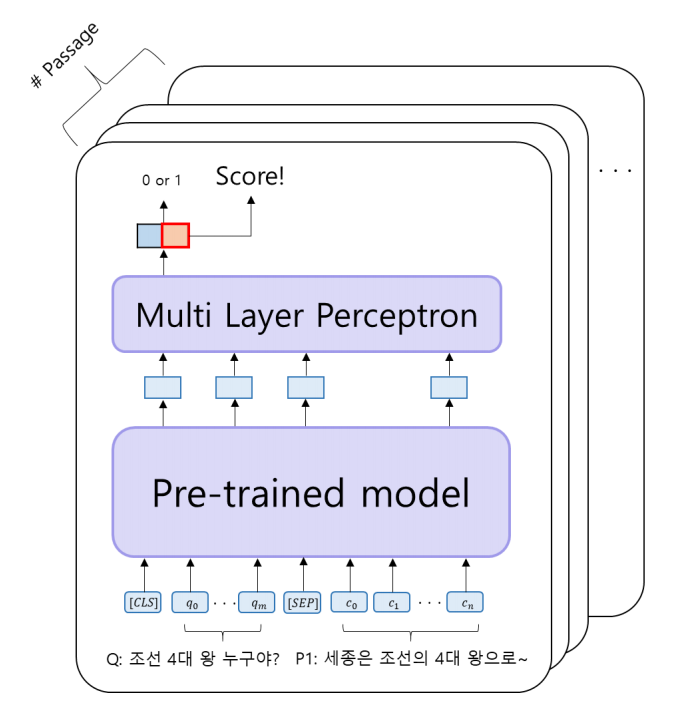

In [14]:
from IPython.display import Image
import os
root_dir = '/gdrive/MyDrive/14-2.PassageReranking'
Image(os.path.join(root_dir, "Reranking_practice.PNG"))

In [15]:
!pip3 install transformers

In [16]:
import torch
from torch import nn
from transformers import ElectraModel, ElectraPreTrainedModel
from tqdm import tqdm
from torch.nn import functional as F
from transformers import ElectraTokenizer, ElectraConfig
from torch.utils.data import (DataLoader, TensorDataset)
import random
import numpy as np

In [17]:
# Model Class
class RerankingModel(ElectraPreTrainedModel):
    def __init__(self, config):
        super(RerankingModel, self).__init__(config)

        # 분류해야할 라벨 수 (0 / 1)
        self.num_labels = config.num_labels

        # ELECTRA 모델 선언
        self.electra = ElectraModel(config)

        # 최종 출력
        self.output_layer_1 = nn.Linear(config.hidden_size, config.hidden_size//2)
        self.output_layer_2 = nn.Linear(config.hidden_size//2, config.num_labels)

    def forward(self, input_ids=None, token_type_ids=None):
        # input_ids : [batch, max_length] => [[1, 5, 3, 4,78, 345, 234, 67, ... ], [...]]
        # token_type_ids : [batch, max_length] => [[0, 0, 0, ..., 1, 1, 1, ..., 0, 0, 0], [...]]

        # ELECTRA output
        outputs = self.electra(input_ids=input_ids,
                               token_type_ids = token_type_ids)
        # ouputs : [1, batch, max_length, hidden_size]

        sequence_output = outputs[0]
        # sequence_output : [batch, max_length, hidden_size]

        # CLS 벡터 추출
        cls_output = sequence_output[:, 0, :]
        # cls_output : [batch, hidden]

        dense_output = self.output_layer_1(cls_output)
        hypothesis = self.output_layer_2(dense_output)
        # hypothesis : [batch, 2]

        return hypothesis

<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. def load_dataset(config, tokenizer, flag):</b>
  학습 또는 평가 데이터를 읽고 고정 길이 텐서로 반환하기 위한 함수
   
  args
    config : 모델 학습 파라미터 및 경로 정보
    tokenizer : Word Piece Tokenize를 위한 Tokenizer
    flag : 학습 데이터 or 평가 데이터에 따른 값
  return  
    q_ids : [batch]
    all_input_ids  : [batch, seq_len]
    all_token_type_ids  : [batch, seq_len]
    all_question_masks  : [batch, seq_len]
    label_ids : [batch]

In [18]:
# 데이터 읽기 함수
def load_dataset(config, tokenizer, flag):
    file_dir = config['train_file'] if flag  else config['test_file']
    data_file = open(os.path.join(config["data_dir"], file_dir),'r',encoding='utf8').readlines()

    # 데이터를 저장하기 위한 리스트 생성
    q_ids, all_input_ids, all_token_type_ids, all_question_masks, \
    label_ids = [], [], [], [], []
    for line in tqdm(data_file):
        q_id, query, passage, label = line.strip().split('\t')
        query_sequence = tokenizer.tokenize(query)
        context_sequence = tokenizer.tokenize(passage)
        encoded_dict = tokenizer.encode_plus(query_sequence, context_sequence, padding='max_length')

        q_ids.append(int(q_id))
        all_input_ids.append(encoded_dict["input_ids"][:config["max_seq_length"]])
        all_token_type_ids.append(encoded_dict["token_type_ids"][:config["max_seq_length"]])
        label_ids.append(int(label))


    # 전체 데이터를 저장하고 있는 리스트를 텐서 형태로 변환
    q_ids = torch.tensor(q_ids, dtype=torch.long)
    all_input_ids = torch.tensor(all_input_ids, dtype=torch.long)
    all_token_type_ids = torch.tensor(all_token_type_ids, dtype=torch.long)
    label_ids = torch.tensor(label_ids, dtype=torch.long)

    return q_ids, all_input_ids, all_token_type_ids, label_ids

In [19]:
def tensor2list(tensor):
    return tensor.detach().cpu().tolist()

# Recall at K
def measure(all_results):
    n_samples = 0
    correct = [0]*10
    for q_id in all_results.keys():
        prediction = [e[1] for e in sorted(all_results[q_id], key=lambda x: x[0], reverse=True)]
        if 1 in prediction:
            correct[prediction.index(1)]+=1
        n_samples+=1
    top_N_scores = [sum(correct[:e+1])/n_samples for e in range(len(correct))]
    return top_N_scores

In [20]:
# 모델의 가중치를 Load하는 부분
def _create_model(config):
    print("Create Model with Pretrained Parameters...")

    # 호출하는 사전학습 모델의 hidden 크기 등을 Load
    electra_config = ElectraConfig.from_pretrained(
        config["init_weight"] if config["mode"] == "train" else os.path.join(config["output_dir"], "checkpoint-{}".format(config["checkpoint"])),
    )

    # 호출하는 사전학습 모델에 맞는 Vocabulary 등을 Load
    electra_tokenizer = ElectraTokenizer.from_pretrained(
        config["init_weight"] if config["mode"] == "train" else os.path.join(config["output_dir"], "checkpoint-{}".format(config["checkpoint"])),
        do_lower_case=config["do_lower_case"],
    )

    # 모델 선언
    model = RerankingModel.from_pretrained(
        config["init_weight"] if config["mode"] == "train" else os.path.join(config["output_dir"], "checkpoint-{}".format(config["checkpoint"])),
        config=electra_config
    )
    model.cuda()

    return model, electra_tokenizer


In [21]:
def train(config, model, tokenizer):
    # 데이터 읽기
    _, all_input_ids, all_token_type_ids, all_labels = load_dataset(config, tokenizer, flag=True)

    # TensorDataset/DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
    train_dataset = TensorDataset(all_input_ids, all_token_type_ids, all_labels)
    train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size=config["batch_size"])

    # optimizer 선언
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    global_step = 0

    # 크로스엔트로피 손실 함수
    criterion = nn.CrossEntropyLoss()

    best_score = 0
    for epoch in range(config["num_epochs"]):
        for step, batch in enumerate(train_dataloader):
            # 학습 모드 셋팅
            model.train()

            # .cuda()를 통해 데이터를 메모리에 업로드
            batch = tuple(t.cuda() for t in batch)
            input_ids, token_type_ids, label_ids = batch

            hypothesis = model(input_ids, token_type_ids)
            # hypothesis : [batch, 2]

            labels = label_ids.view(-1,)

            # Loss 계산 및 역전파
            loss = criterion(hypothesis, labels)
            loss.backward()

            optimizer.step()
            model.zero_grad()

            # 중간 결과 출력
            if (global_step + 1) % 50 == 0:
                print("{} step Current Loss : {}".format(global_step + 1, loss.item()))

            # 특정 checkpoint 마다 저장 및 평가
            if (global_step + 1) % 2000 == 0:
                top_N_score = do_test(config, model, tokenizer)

                # 모델 저장을 위한 부분
                output_dir = os.path.join(config["output_dir"], "checkpoint-{}".format(global_step+1))

                # 모델 및 vocab 저장
                model.save_pretrained(output_dir)
                tokenizer.save_pretrained(output_dir)

                if best_score < top_N_score[0]:
                    best_score = top_N_score[0]
                    torch.save(model.state_dict(), os.path.join(output_dir, "training_args.bin"))
                    print("Saving model checkpoint to ", output_dir)
            global_step += 1
    return global_step

def do_test(config, model, tokenizer):
    # 데이터 읽기
    all_ids, all_input_ids, all_token_type_ids, all_labels = load_dataset(config, tokenizer, flag=False)

    # TensorDataset/DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
    test_dataset = TensorDataset(all_ids, all_input_ids, all_token_type_ids, all_labels)
    test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config["batch_size"])

    # 모델 출력 결과를 저장하기위한 dictionary
    all_results = {}

    for step, batch in enumerate(tqdm(test_dataloader)):
        # 평가 모드 세팅
        model.eval()

        # .cuda()를 통해 데이터를 메모리에 업로드
        batch = tuple(t.cuda() for t in batch)
        with torch.no_grad():
            q_ids, input_ids, token_type_ids, labels = batch

            hypothesis = model(input_ids, token_type_ids)

            # Softmax 함수를 통해 입력 데이터에 대한 점수 계산
            probs = tensor2list(F.softmax(hypothesis, -1)[:, 1])

        # 각 데이터에 해당하는 q_id로 결과 저장
        batch_size = hypothesis.size(0)
        q_ids = tensor2list(q_ids)
        labels = tensor2list(labels)
        for i in range(batch_size):
            cur_q_id = q_ids[i]
            if cur_q_id not in all_results.keys():
                all_results[cur_q_id] = []
            all_results[cur_q_id].append((probs[i], labels[i]))

    # 성능 평가
    top_N_score = measure(all_results)
    for N in range(len(top_N_score)):
        print("\nTop {} Recall Score : {:.3f}".format(N+1, top_N_score[N]))
    return top_N_score

In [22]:
if __name__ == "__main__":
    output_dir = os.path.join(root_dir, "output")
    data_dir = os.path.join(root_dir, "data")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    config = {
        "mode": "train",
        "data_dir": data_dir,
        "output_dir": output_dir,
        "train_file": "refine_train_small.txt",
        "test_file": "refine_test.txt",
        "init_weight": "monologg/koelectra-small-v3-discriminator",
        "do_lower_case": False,
        "checkpoint":6000,
        "batch_size": 16,
        "num_epochs": 3,
        "max_seq_length": 512,
        "learning_rate": 5e-5,
    }
    model, tokenizer = _create_model(config)
    if config["mode"] == "train":
        train(config, model, tokenizer)
    elif config["mode"] == "test":
        results = do_test(config, model, tokenizer)


Create Model with Pretrained Parameters...


Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing RerankingModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing RerankingModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RerankingModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RerankingModel were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['output_layer_2.weight', 'output_layer_1.weight', 'output_layer_2.bia

50 step Current Loss : 0.5277736783027649
100 step Current Loss : 0.54799485206604
150 step Current Loss : 0.30024591088294983
200 step Current Loss : 0.21104416251182556
250 step Current Loss : 0.3431752920150757
300 step Current Loss : 0.2915109694004059
350 step Current Loss : 0.2621276378631592
400 step Current Loss : 0.31099408864974976
450 step Current Loss : 0.43667834997177124
500 step Current Loss : 0.0686509981751442
550 step Current Loss : 0.26362770795822144
600 step Current Loss : 0.13871097564697266
650 step Current Loss : 0.05409230291843414
700 step Current Loss : 0.04553037881851196
750 step Current Loss : 0.3598814010620117
800 step Current Loss : 0.07988264411687851
850 step Current Loss : 0.3113814890384674
900 step Current Loss : 0.23410552740097046
950 step Current Loss : 0.1054081991314888
1000 step Current Loss : 0.30310654640197754
1050 step Current Loss : 0.11581244319677353
1100 step Current Loss : 0.35510513186454773
1150 step Current Loss : 0.39548355340957

100%|██████████| 301/301 [00:29<00:00, 10.20it/s]



Top 1 Recall Score : 0.944

Top 2 Recall Score : 0.960

Top 3 Recall Score : 0.974

Top 4 Recall Score : 0.974

Top 5 Recall Score : 0.976

Top 6 Recall Score : 0.978

Top 7 Recall Score : 0.980

Top 8 Recall Score : 0.982

Top 9 Recall Score : 0.982

Top 10 Recall Score : 0.982
Saving model checkpoint to  /gdrive/MyDrive/강의자료 모음/[2021] LG 전자/05-1. Docuement Re-ranking/practice/output/checkpoint-2000
2050 step Current Loss : 0.10935324430465698
2100 step Current Loss : 0.11944431066513062
2150 step Current Loss : 0.2205813229084015
2200 step Current Loss : 0.3550032675266266
2250 step Current Loss : 0.2287871241569519
2300 step Current Loss : 0.3250044882297516
2350 step Current Loss : 0.13249175250530243
2400 step Current Loss : 0.2604144811630249
2450 step Current Loss : 0.14395344257354736
2500 step Current Loss : 0.25896984338760376
2550 step Current Loss : 0.1783899962902069
2600 step Current Loss : 0.6868864893913269
2650 step Current Loss : 0.026867065578699112
2700 

100%|██████████| 301/301 [00:29<00:00, 10.20it/s]



Top 1 Recall Score : 0.948

Top 2 Recall Score : 0.964

Top 3 Recall Score : 0.972

Top 4 Recall Score : 0.976

Top 5 Recall Score : 0.978

Top 6 Recall Score : 0.978

Top 7 Recall Score : 0.978

Top 8 Recall Score : 0.982

Top 9 Recall Score : 0.982

Top 10 Recall Score : 0.982
Saving model checkpoint to  /gdrive/MyDrive/강의자료 모음/[2021] LG 전자/05-1. Docuement Re-ranking/practice/output/checkpoint-4000
4050 step Current Loss : 0.2006305307149887
4100 step Current Loss : 0.0426078736782074
4150 step Current Loss : 0.16125530004501343
4200 step Current Loss : 0.15719296038150787
4250 step Current Loss : 0.088014155626297
4300 step Current Loss : 0.26289674639701843
4350 step Current Loss : 0.12097038328647614
4400 step Current Loss : 0.029056163504719734
4450 step Current Loss : 0.1886267215013504
4500 step Current Loss : 0.2287611961364746
4550 step Current Loss : 0.051834166049957275
4600 step Current Loss : 0.19014286994934082
4650 step Current Loss : 0.21968337893486023
470

100%|██████████| 301/301 [00:29<00:00, 10.21it/s]



Top 1 Recall Score : 0.948

Top 2 Recall Score : 0.960

Top 3 Recall Score : 0.976

Top 4 Recall Score : 0.976

Top 5 Recall Score : 0.978

Top 6 Recall Score : 0.978

Top 7 Recall Score : 0.980

Top 8 Recall Score : 0.982

Top 9 Recall Score : 0.982

Top 10 Recall Score : 0.982
6050 step Current Loss : 0.09723325073719025
6100 step Current Loss : 0.016145288944244385
6150 step Current Loss : 0.03697086125612259
6200 step Current Loss : 0.06752216815948486
6250 step Current Loss : 0.3031872808933258
6300 step Current Loss : 0.03156840056180954
6350 step Current Loss : 0.19457168877124786
6400 step Current Loss : 0.20589031279087067
6450 step Current Loss : 0.022677822038531303
6500 step Current Loss : 0.20893976092338562
6550 step Current Loss : 0.18794013559818268
6600 step Current Loss : 0.26174822449684143
6650 step Current Loss : 0.035365935415029526
6700 step Current Loss : 0.04125523567199707
6750 step Current Loss : 0.11383549869060516
6800 step Current Loss : 0.033789984881877

100%|██████████| 301/301 [00:29<00:00, 10.24it/s]



Top 1 Recall Score : 0.950

Top 2 Recall Score : 0.962

Top 3 Recall Score : 0.976

Top 4 Recall Score : 0.978

Top 5 Recall Score : 0.980

Top 6 Recall Score : 0.980

Top 7 Recall Score : 0.980

Top 8 Recall Score : 0.980

Top 9 Recall Score : 0.980

Top 10 Recall Score : 0.982
Saving model checkpoint to  /gdrive/MyDrive/강의자료 모음/[2021] LG 전자/05-1. Docuement Re-ranking/practice/output/checkpoint-8000
8050 step Current Loss : 0.02371145784854889
8100 step Current Loss : 0.0401884987950325
8150 step Current Loss : 0.035768937319517136
8200 step Current Loss : 0.013497797772288322
8250 step Current Loss : 0.0432373471558094
8300 step Current Loss : 0.012874956242740154
8350 step Current Loss : 0.1518232226371765
8400 step Current Loss : 0.04122947156429291
8450 step Current Loss : 0.01022384874522686
8500 step Current Loss : 0.1165870949625969
8550 step Current Loss : 0.024500440806150436
8600 step Current Loss : 0.012036915868520737
8650 step Current Loss : 0.0854557156562805

100%|██████████| 301/301 [00:29<00:00, 10.24it/s]



Top 1 Recall Score : 0.944

Top 2 Recall Score : 0.960

Top 3 Recall Score : 0.976

Top 4 Recall Score : 0.978

Top 5 Recall Score : 0.978

Top 6 Recall Score : 0.980

Top 7 Recall Score : 0.982

Top 8 Recall Score : 0.982

Top 9 Recall Score : 0.982

Top 10 Recall Score : 0.982
10050 step Current Loss : 0.29078778624534607
10100 step Current Loss : 0.024692950770258904
10150 step Current Loss : 0.10216012597084045
10200 step Current Loss : 0.009546574205160141
10250 step Current Loss : 0.009881534613668919
10300 step Current Loss : 0.01896219700574875
10350 step Current Loss : 0.08986447006464005
10400 step Current Loss : 0.15904009342193604
10450 step Current Loss : 0.012963559478521347
10500 step Current Loss : 0.1105518639087677
10550 step Current Loss : 0.038822658360004425
10600 step Current Loss : 0.036979738622903824
10650 step Current Loss : 0.3025771975517273
10700 step Current Loss : 0.08067401498556137
10750 step Current Loss : 0.10958721488714218
10800 step Current Loss :

100%|██████████| 301/301 [00:29<00:00, 10.23it/s]



Top 1 Recall Score : 0.952

Top 2 Recall Score : 0.966

Top 3 Recall Score : 0.978

Top 4 Recall Score : 0.978

Top 5 Recall Score : 0.978

Top 6 Recall Score : 0.980

Top 7 Recall Score : 0.982

Top 8 Recall Score : 0.982

Top 9 Recall Score : 0.982

Top 10 Recall Score : 0.982
Saving model checkpoint to  /gdrive/MyDrive/강의자료 모음/[2021] LG 전자/05-1. Docuement Re-ranking/practice/output/checkpoint-12000
12050 step Current Loss : 0.4077526032924652
12100 step Current Loss : 0.19763560593128204
12150 step Current Loss : 0.08386059105396271
12200 step Current Loss : 0.0350937694311142
12250 step Current Loss : 0.02180076390504837
12300 step Current Loss : 0.007190565578639507
12350 step Current Loss : 0.032536253333091736
12400 step Current Loss : 0.02783038094639778
12450 step Current Loss : 0.00550855090841651
12500 step Current Loss : 0.011377664282917976
12550 step Current Loss : 0.003967056982219219
12600 step Current Loss : 0.012323879636824131
12650 step Current Loss : 0.

<pre>
Top  1 Recall : 0.868
Top  2 Recall : 0.911
Top  3 Recall : 0.944
Top  4 Recall : 0.954
Top  5 Recall : 0.964
Top  6 Recall : 0.968
Top  7 Recall : 0.973
Top  8 Recall : 0.974
Top  9 Recall : 0.982
Top 10 Recall : 0.982